# Session making

На этом этапе необходимо отделить сессии каждого пользователя. Запросы пользователя относятся к разным сессиям, если между ними прошло более некоторого фиксированного количества времени.

In [1]:
import pandas as pd
from tqdm.notebook import tqdm
from itertools import groupby
from numpy import timedelta64
import sys

In [2]:
dtype = {
    'time': 'str',
    'request_uri': 'str',
    'user_id': 'int'
}

In [3]:
data = pd.read_csv('data_with_uids.csv', parse_dates=['time'])
data.head()

,time,user_id,request_uri
0,2022-02-07 11:40:25.020,4761465809854368106,/goods/324570/gz0473/
1,2022-02-07 11:40:25.026,4761465809854368106,/goods/338875/dh3718-105/
2,2022-02-07 11:40:25.046,14823100236334183709,/getproductsize/339316/
3,2022-02-07 11:40:25.047,14823100236334183709,/getproductsize/342531/
4,2022-02-07 11:40:25.052,14823100236334183709,/getproductsize/338875/


Взгляд из будущего, поэтому есть колонка session_id.

Изначально планировалось поставить 30-минутный интервал, но тогда проявляются такие случаи - один запрос ровно каждые 30 минут. Так мы генерируем очень много однозапросных сессий, причем явно автоматических. При исследовании данных были найдены аналогичные сессии с одним запросом каждый час и т.д. 

Обрабатывая данные постфактум, такие сессии можно было бы объединить, вычисляя одинаковые интервалы между запросами. Но т.к. изначальная цель исследования - работа в высоконагруженных системах, в которых информация о предыдущем запросе хранилась бы в кэшах, а размеры кэшей не безграничны, то на данном этапе мы проигнорируем эти экстремальные случаи. Установим время между сессиями между чуть больше часа.

In [44]:
data[data.user_id == 9939449780910933933].iloc[:10]

,time,user_id,request_uri,session_id
2862012,2022-02-07 12:30:31.246,9939449780910933933,/goods/307314/gz7925/?utm_source=admitad&utm_m...,1090664216913957605
2862013,2022-02-07 13:00:44.770,9939449780910933933,/goods/307314/gz7925/?utm_source=admitad&utm_m...,17369990914576409682
2862014,2022-02-07 13:31:32.107,9939449780910933933,/goods/307314/gz7925/?utm_source=admitad&utm_m...,15834699945482332110
2862015,2022-02-07 14:01:36.960,9939449780910933933,/goods/307314/gz7925/?utm_source=admitad&utm_m...,14243134369053703796
2862016,2022-02-07 14:32:01.612,9939449780910933933,/goods/307314/gz7925/?utm_source=admitad&utm_m...,484967644754431213
2862017,2022-02-07 15:01:52.619,9939449780910933933,/goods/307314/gz7925/?utm_source=admitad&utm_m...,484967644754431213
2862018,2022-02-07 15:32:10.059,9939449780910933933,/goods/307314/gz7925/?utm_source=admitad&utm_m...,6569447469050011601
2862019,2022-02-07 16:03:07.059,9939449780910933933,/goods/307314/gz7925/?utm_source=admitad&utm_m...,3782797762208600156
2862020,2022-02-07 16:33:25.588,9939449780910933933,/goods/307314/gz7925/?utm_source=admitad&utm_m...,7426380994846504448
2862021,2022-02-07 17:03:27.351,9939449780910933933,/goods/307314/gz7925/?utm_source=admitad&utm_m...,14182184636990323995


In [29]:
data = data.sort_values([key_column, 'time']).reset_index(drop=True)

Алгоритм описывать нет смысла, т.к. результат его работы ясен.

In [30]:
def get_session_id(data, key_column, session_time_delta):
    user_idx = []
    session_ids = []
    n_users = data[key_column].nunique()
    key_idx = data.columns.to_list().index(key_column)
    for _, sessions in tqdm(groupby(data.itertuples(), key=lambda x: x[key_idx+1]), total=n_users):
        sessions = pd.DataFrame(list(sessions)).set_index('Index')
        user_idx += sessions.index.to_list()
        sessions = sessions.reset_index(drop=True)
        sessions['time_delta'] = (sessions.time.diff() / timedelta64(1, 's')).fillna(0).astype('int')
        sessions['session_end'] = sessions['time_delta'] >= session_time_delta
        sessions_sep = sessions[sessions['session_end']].index.to_list()
        sessions_sep.append(len(sessions))
        start_idx = 0
        for sep in sessions_sep:
            session_id = hash(tuple(sessions.loc[start_idx, ['time', key_column]])) + sys.maxsize + 1
            session_ids += [session_id] * (sep - start_idx)
            start_idx = sep
    return [x for _, x in sorted(zip(user_idx, session_ids))]

In [59]:
data['session_id'] = get_session_id(data, 'user_id', 3610)

  0%|          | 0/133150 [00:00<?, ?it/s]

Взглянем на пользователя с самым высоким количеством сессий.

In [60]:
data.groupby('user_id').nunique().sort_values('session_id')[['session_id']]

,session_id
user_id,
141794952076039,1
11862430843268585240,1
11862196800186121998,1
11862135496675336285,1
11861724342804615139,1
...,...
12431648224065138427,14
4498887783926750954,15
17626080394710213342,19


Между запросами прошел 1 час и полторы минуты. С учетом того, сессии получились не однозапросными, то результат приемлем.

In [61]:
data[data.user_id == 16093171809055456616].iloc[:10]

,time,user_id,request_uri,session_id
4886220,2022-02-07 12:22:05.448,16093171809055456616,/,7933271405150888027
4886221,2022-02-07 12:22:05.610,16093171809055456616,/,7933271405150888027
4886222,2022-02-07 12:22:05.885,16093171809055456616,/,7933271405150888027
4886223,2022-02-07 12:22:06.112,16093171809055456616,/,7933271405150888027
4886224,2022-02-07 12:22:06.279,16093171809055456616,/,7933271405150888027
4886225,2022-02-07 12:22:06.455,16093171809055456616,/,7933271405150888027
4886226,2022-02-07 13:23:28.419,16093171809055456616,/,6153582191130136406
4886227,2022-02-07 13:23:28.637,16093171809055456616,/,6153582191130136406
4886228,2022-02-07 13:23:28.800,16093171809055456616,/,6153582191130136406
4886229,2022-02-07 13:23:28.992,16093171809055456616,/,6153582191130136406


Для дальнейших исследований будет полезно выяснить, какой вообще длины сессии в наших данных

In [62]:
session_lengths = data.session_id.value_counts()

In [76]:
session_lengths[session_lengths < 10].shape[0] / session_lengths.shape[0]

0.7408286074542402

In [64]:
session_lengths[session_lengths > 100].shape[0] / session_lengths.shape[0]

0.019732163665808142

<AxesSubplot:>

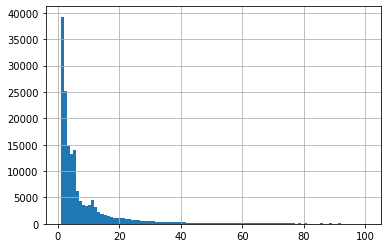

In [71]:
session_lengths[session_lengths <= 100].hist(bins=100)

In [65]:
data.loc[:, ['time', 'session_id', 'request_uri']].to_csv('data_with_sess_id.csv', index=False)